# DTMのコードの関数作成
* time_sliceの作成
 * 年月別ユーザー数でtime_sliceを作成する
* 上記で作成した年月別ユーザー数をリスト化する
* corpus作成のデータ準備
 * ユーザーの年月別購買商品を取得する
 * リスト化
 * ※ここで、ユーザーIDとユーザーの購買履歴を対応づける作業を行う。
* DTMのデータ準備
 * cat4の辞書の作成
 * corpus作成
* DTM実装
 * トピック数を指定する
 * モデルを実行し、モデルを保存する
* DTM結果の可視化
 * 各トピックの年月別割合推移を可視化する
 * サンキーダイアグラムを用いて


In [1]:
pip install japanize-matplotlib

In [2]:
import japanize_matplotlib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
target_data_food = pd.read_csv("med_cat1_food_data_target_user10_2500.csv", index_col=0)

In [5]:
#日付データの形式変更
target_data_food['receipt_buydate'] = pd.to_datetime(target_data_food['receipt_buydate'])

In [6]:
pip install gensim nltk

Note: you may need to restart the kernel to use updated packages.


# classを使ってdtmの前処理を記述

In [7]:
from gensim import corpora, models
import pandas as pd

class Pre_dtm:
    def __init__(self, target_data_food):
        self.target_data_food = target_data_food
        self.user_time_slice = None
        self.user_cat4_ym = None
        self.indices_by_id = None
        self.dictionary = None
        self.corpus = None

    def create_time_slice(self):
        unique_user_count = self.target_data_food.groupby(self.target_data_food['receipt_buydate'].dt.to_period("M"))['id'].nunique().reset_index()
        unique_user_count.columns = ['receipt_buydate', 'unique_user_count']
        self.user_time_slice = unique_user_count['unique_user_count'].tolist()
        return self.user_time_slice

    def prepare_corpus_data(self):
        grouped_cat4_data = self.target_data_food.groupby([self.target_data_food['receipt_buydate'].dt.to_period("M"), 'id'])['cat4'].apply(lambda x: [product.strip() for product in x]).reset_index()
        self.user_cat4_ym = grouped_cat4_data['cat4'].tolist()
        date_range = pd.date_range(start='2014-04-01', end='2015-03-31', freq='M').strftime('%Y-%m').tolist()
        self.indices_by_id = grouped_cat4_data.groupby('id').apply(lambda group: [group[group['receipt_buydate'].dt.strftime('%Y-%m') == month].index[0].tolist() if month in group['receipt_buydate'].dt.strftime('%Y-%m').tolist() else 'NA' for month in date_range])

        return self.user_cat4_ym, self.indices_by_id

    def create_dictionary(self):
        texts = self.target_data_food['cat4'].tolist()
        processed_docs = [[str(doc).lower().strip()] for doc in texts]
        self.dictionary = corpora.Dictionary(processed_docs)
        return self.dictionary

    def create_corpus(self):
        if self.dictionary is None:
            self.create_dictionary()
        if self.user_cat4_ym is None:
            self.prepare_corpus_data()
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.user_cat4_ym]
        return self.corpus

    def analyze(self):
        self.create_time_slice()
        self.prepare_corpus_data()
        self.create_dictionary()
        self.create_corpus()
        return {
            'time_slice': self.user_time_slice,
            'corpus_data': (self.user_cat4_ym, self.indices_by_id),
            'dictionary': self.dictionary,
            'corpus': self.corpus
        }

In [8]:
# Assuming you have your target_data_food DataFrame
analyzer = Pre_dtm(target_data_food)
results = analyzer.analyze()

# Access the results
user_time_slice = results['time_slice']
user_cat4_ym, indices_by_id = results['corpus_data']
dictionary = results['dictionary']
corpus = results['corpus']

# DTM実装

In [17]:
# #時系列でのトピックの確率を取得
#     for time in range(len(user_time_slice)):
#         topics_at_time_t = ldaseq.print_topics(time=time)
#         for topic_id, topic_prob in enumerate(topics_at_time_t):
#             print(topic_id, topic_prob[0:5])

In [15]:
user_time_slice = results['time_slice']

In [13]:
from gensim.models import LdaSeqModel
import numpy as np
import datetime

# トピック数を指定,データのタイプを指定
num_topics = 10
data_type = 'med'
def run_dtm(num_topics, user_time_slice, corpus, dictionary):
    ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=user_time_slice, num_topics=num_topics)
    ldaseq.save(f'dtm_cat4_{num_topics}_{data_type}.pkl')


def vis_dtm_result(user_time_slice, num_topic, data_type):
    #各トピックの年月別割合推移を可視化する
    cumulative_list = [sum(user_time_slice[:i+1]) for i in range(len(user_time_slice))]
    #モデルの読み込み
    ldaseq = LdaSeqModel.load(f'dtm_cat4_{num_topics}_{data_type}.pkl')
    # トピックの割合を計算
    time_topic_prob = {}
    start = 0
    for num, index in enumerate(cumulative_list):
        # 各トピックの確率を効率的に平均化
        topic_probs = np.mean(ldaseq.doc_topics(range(start,index)), axis = 0)

        # 結果を格納
        time_topic_prob[num] = topic_probs

        # 次の時間帯の開始点を更新
        start = index
    #可視化の際のインデックスを取得
    times_ = list(target_data_food['receipt_buydate'].dt.to_period("M").unique())
    times_ = [str(str_time) for str_time in times_]
    times_ = sorted(times_, key=lambda x: datetime.datetime.strptime(x, "%Y-%m"))

    # データの準備
    data = time_topic_prob
    # データを時間とトピック別に整理
    times = list(data.keys())
    topic_prob_data = [[data[t][s] for t in times] for s in range(num_topic)]
    for i in range(num_topic):
        plt.plot(times_, topic_prob_data[i],label=f'Topic{i}')
    # グラフのスタイリング
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Topic Proportion', fontsize=12)
    plt.title('Topic Evolution Over Time', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{data_type}propotion.png", dpi=700)
    plt.show()
    print(topic_prob_data)
    print(data)

C:\Users\nama\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


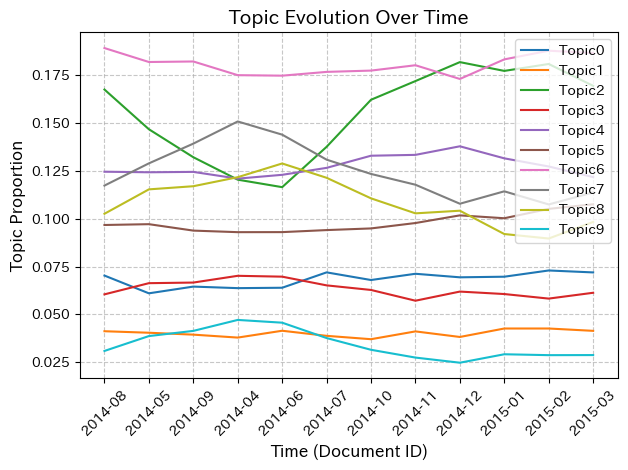

In [21]:
run_dtm(num_topics, user_time_slice, corpus, dictionary)

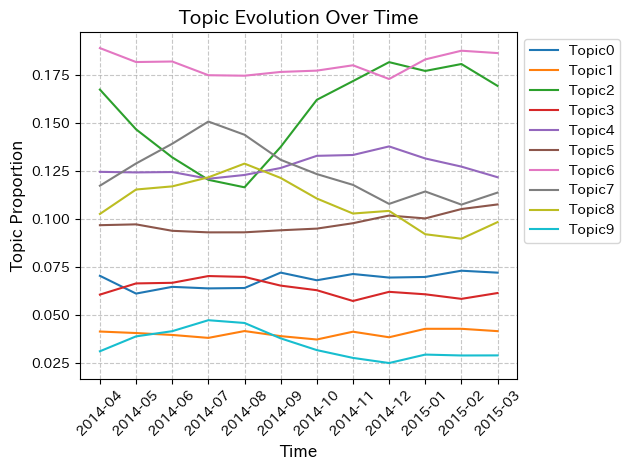

[[0.0702819239853116, 0.06102145854450055, 0.06452847335999384, 0.06372353617868053, 0.0639279694811693, 0.07194587226653446, 0.06796068201072439, 0.0712148083979913, 0.06937074772215918, 0.06968529388307071, 0.07293693010213381, 0.07192119835587456], [0.04125605553818322, 0.04046746094355362, 0.03947589290385262, 0.037942390767086887, 0.04150530249150561, 0.038852232508273944, 0.0370979327019607, 0.04116583924784912, 0.03826284163889941, 0.042672999342124575, 0.04267563973014525, 0.04145660667188762], [0.16728939412139623, 0.14658048046803712, 0.13199119246983293, 0.12028670274886519, 0.11638162304172822, 0.13741541633553392, 0.16196007600327914, 0.1717043635035952, 0.18158661539739757, 0.17700263070328712, 0.18061087189563668, 0.16922092849938694], [0.06048538669831186, 0.06631361730215457, 0.06663367699222746, 0.07015484507415617, 0.06971052807823659, 0.06516908699944945, 0.0627769232230559, 0.05716967555513525, 0.061930353329866766, 0.06064851970065814, 0.05827130592806343, 0.06130

In [16]:
vis_dtm_result(user_time_slice, num_topics, data_type)

In [10]:
ldaseq = LdaSeqModel.load('dtm_cat4_10_med.pkl')

In [11]:
#時系列でのトピックの確率を取得
user_time_slice = 12
tmp_dic = {}
for time in range(user_time_slice):
    topics_at_time_t = ldaseq.print_topics(time=time)
    for topic_id, topic_prob in enumerate(topics_at_time_t):
        print(topic_id, topic_prob[0:5])
        tmp_dic[topic_id] = topic_prob[0:5]
pd.DataFrame(tmp_dic)

0 [('菓子パン・調理パン', 0.8075226050918874), ('食パン', 0.0636330799344817), ('ヨ－グルト', 0.017040045829014965), ('牛乳', 0.01659460668506322), ('コ－ヒ－ドリンク', 0.01085992126059652)]
1 [('冷凍調理', 0.6288112659598986), ('ベビ－フ－ド', 0.2137615048070691), ('冷凍農産', 0.037956133828957406), ('育児用粉ミルク', 0.024538907181565657), ('畜肉ソ－セ－ジ', 0.012032179005587973)]
2 [('チョコレ－ト', 0.279429902504582), ('ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-', 0.21661840487483386), ('キャンディ', 0.19023328042687968), ('煎餅・あられ', 0.1582148118250282), ('デザ－ト類', 0.03520678292125894)]
3 [('その他酒類', 0.2488043969243275), ('ビ－ル', 0.21931798810924544), ('つまみ類', 0.10804841457066203), ('炭酸飲料', 0.07722920508228355), ('コ－ラ', 0.06401897195451081)]
4 [('カレ－', 0.08313482073186257), ('ふりかけ', 0.06329739335433929), ('まぜご飯の素', 0.0500304690995266), ('パスタソ－ス', 0.04439289841765749), ('ス－プ類', 0.041813751157263664)]
5 [('スナック', 0.6991064511868349), ('チョコレ－ト', 0.07483998049909153), ('煎餅・あられ', 0.06606755803418939), ('ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-', 0.05982084706862436), ('炭酸飲料', 0.0193628739027077)]
6 [('牛乳', 0.170

,0,1,2,3,4,5,6,7,8,9
0,"(菓子パン・調理パン, 0.7742885468194957)","(冷凍調理, 0.6584311691038652)","(チョコレ－ト, 0.2912165355041574)","(その他酒類, 0.2608428793757742)","(カレ－, 0.07273814841779819)","(スナック, 0.662366540343861)","(牛乳, 0.1534305120204202)","(栄養バランス食品, 0.2376528612714897)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.4216315710486616)","(アイスクリ－ム, 0.5195108704434234)"
1,"(食パン, 0.0679435510129096)","(ベビ－フ－ド, 0.15465710660397874)","(ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-, 0.23070714283511543)","(ビ－ル, 0.22982115731192285)","(ス－プ類, 0.06420918341583996)","(チョコレ－ト, 0.08393067770040631)","(ヨ－グルト, 0.12434222220057603)","(スポ－ツドリンク, 0.20637772849211874)","(液体茶, 0.17695203044551427)","(１００％ジュ－ス, 0.17312485709388903)"
2,"(その他菓子, 0.021216093132755548)","(冷凍農産, 0.03571594901837831)","(キャンディ, 0.19178702488813712)","(つまみ類, 0.0991430191648129)","(ふりかけ, 0.06227176208297542)","(ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-, 0.08020035743476508)","(食パン, 0.09287320266628012)","(栄養ドリンク, 0.11100748149956105)","(コ－ヒ－ドリンク, 0.10514871504020687)","(牛乳, 0.042929447992834054)"
3,"(牛乳, 0.01963742892287751)","(たばこ, 0.03261170707467064)","(煎餅・あられ, 0.1481463512391045)","(炭酸飲料, 0.0737668056859321)","(パスタソ－ス, 0.05460159646014859)","(煎餅・あられ, 0.0677260901061337)","(豆腐類, 0.07034898032130202)","(デザ－ト類, 0.08937912715271426)","(ミネラルウォ－タ類, 0.04660642503334822)","(炭酸飲料, 0.03835664403786456)"
4,"(ヨ－グルト, 0.012389755545428417)","(育児用粉ミルク, 0.021197969457205743)","(つまみ類, 0.024412313483971108)","(焼酎, 0.07196635496525695)","(まぜご飯の素, 0.049334200057023644)","(炭酸飲料, 0.021546909727980797)","(納豆, 0.06564173195393784)","(野菜ジユ－ス, 0.06534959718131214)","(紅茶ドリンク, 0.03952848604790816)","(ヨ－グルト, 0.038272761493371256)"


In [17]:
# 年月リスト（例: 2014年4月～2015年3月）
time_labels = pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()

# 検証用: 出力する全データを保持するリスト
all_rows = []

# トピックデータの処理とラベル付け
for time, label in enumerate(time_labels):
    topics_at_time_t = ldaseq.print_topics(time=time)  # 各タイムスライスのトピックを取得
    rows = []
    for topic_id, topic in enumerate(topics_at_time_t):
        # トピックごとのデータ整形
        row = {"年月": label, "トピック": topic_id}
        for rank, (word, prob) in enumerate(topic[:5], start=1):  # 上位5つを取得
            row[f"{rank} 位"] = f"{word} ({prob:.3f})"
        rows.append(row)
    all_rows.extend(rows)  # 全タイムスライスのデータをまとめる

# データフレーム化
df = pd.DataFrame(all_rows)
output_file = "dtm_topic/dtm_topic_med.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

# サンキーダイアグラムの可視化

In [18]:
from collections import defaultdict
import numpy as np

def analyze_cluster_transitions(indices_by_id, ldaseq):
    def create_user_cluster_dict(indices_by_id, ldaseq):
        # indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        # indices_by_id.columns = ['id', 'doc_list']
        # user_cluster_dic = {}
        # for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
        #     clus_list = []
        #     num = 0
        #     for doc_num in doc_list:
        #         bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
        #         clus_list.append(f'{bel_ind}_{num}')
        #         num += 1
        #     user_cluster_dic[id] = clus_list
        user_cluster_dic={}
        indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        indices_by_id.columns = ['id', 'doc_list']
        for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
            clus_list = []
            num = 0
            for doc_num in doc_list:
                if doc_num == 'NA':
                    clus_list.append(f'{100}_{num}')
                else:
                    bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
                    clus_list.append(f'{bel_ind}_{num}')
                num += 1
            user_cluster_dic[id] = clus_list
        return user_cluster_dic

    def count_transitions(cluster_sequences):
        transition_counts = defaultdict(int)
        for cluster_sequence in cluster_sequences:
            for i in range(len(cluster_sequence) - 1):
                current_cluster = cluster_sequence[i]
                next_cluster = cluster_sequence[i + 1]
                transition = (current_cluster, next_cluster)
                transition_counts[transition] += 1
        return transition_counts

    def prepare_sankey_data(transition_counts):
        source = []
        target = []
        values_list = []
        for item, value in transition_counts.items():
            source.append(item[0])
            target.append(item[1])
            values_list.append(value)
        return source, target, values_list

    user_cluster_dic = create_user_cluster_dict(indices_by_id, ldaseq)
    cluster_sequences = user_cluster_dic.values()
    transition_counts = count_transitions(cluster_sequences)

    # 結果の出力
    for transition, count in transition_counts.items():
        print(f"遷移 {transition} は {count} 回発生しました。")

    source, target, values_list = prepare_sankey_data(transition_counts)

    return user_cluster_dic, transition_counts, source, target, values_list

In [19]:
# indices_by_id と ldaseq が既に定義されていると仮定
user_cluster_dic, transition_counts, source, target, values_list = analyze_cluster_transitions(indices_by_id, ldaseq)

# 返された値を使って後続の処理を行う
# 例: サンキーダイアグラムの作成など

遷移 ('100_0', '4_1') は 282 回発生しました。
遷移 ('4_1', '7_2') は 87 回発生しました。
遷移 ('7_2', '7_3') は 515 回発生しました。
遷移 ('7_3', '7_4') は 529 回発生しました。
遷移 ('7_4', '6_5') は 97 回発生しました。
遷移 ('6_5', '7_6') は 66 回発生しました。
遷移 ('7_6', '7_7') は 414 回発生しました。
遷移 ('7_7', '4_8') は 73 回発生しました。
遷移 ('4_8', '100_9') は 284 回発生しました。
遷移 ('100_9', '7_10') は 295 回発生しました。
遷移 ('7_10', '100_11') は 269 回発生しました。
遷移 ('7_0', '7_1') は 368 回発生しました。
遷移 ('7_1', '7_2') は 469 回発生しました。
遷移 ('7_4', '3_5') は 41 回発生しました。
遷移 ('3_5', '7_6') は 31 回発生しました。
遷移 ('7_7', '7_8') は 373 回発生しました。
遷移 ('7_8', '7_9') は 368 回発生しました。
遷移 ('7_9', '7_10') は 333 回発生しました。
遷移 ('7_10', '7_11') は 341 回発生しました。
遷移 ('2_0', '1_1') は 31 回発生しました。
遷移 ('1_1', '1_2') は 129 回発生しました。
遷移 ('1_2', '0_3') は 18 回発生しました。
遷移 ('0_3', '8_4') は 36 回発生しました。
遷移 ('8_4', '1_5') は 26 回発生しました。
遷移 ('1_5', '0_6') は 11 回発生しました。
遷移 ('0_6', '1_7') は 13 回発生しました。
遷移 ('1_7', '6_8') は 45 回発生しました。
遷移 ('6_8', '1_9') は 46 回発生しました。
遷移 ('1_9', '1_10') は 136 回発生しました。
遷移 ('1_10', '1_11') は 133 回発生しました。
遷移 ('6_

In [20]:
#遷移行列を作成するためのコード
transtion_data = []
for (from_state,to_state), count in transition_counts.items():
    cluster_f, time_f = from_state.split('_')
    cluster_t, time_t = to_state.split('_')
    if cluster_f == "100" and cluster_t == "100":
        from_state = f'10_{time_f}'
        to_state = f'10_{time_t}'
        transtion_data.append((from_state, to_state, count))
    elif cluster_f == "100":
        from_state = f'10_{time_f}'
        transtion_data.append((from_state, to_state, count))
    elif cluster_t == "100":
        to_state = f'10_{time_t}'
        transtion_data.append((from_state, to_state, count))
    else:
        transtion_data.append((from_state, to_state, count))

In [21]:
import pandas as pd
from collections import defaultdict

def create_time_dependent_transition_matrices(data):
    """
    時点ごとの遷移行列を作成する関数
    
    :param data: (from_state, to_state, count) の形式のデータリスト
    :return: 時点ごとの遷移行列を含む辞書
    """
    # クラスタと時点の情報を抽出
    all_clusters = set()
    all_timepoints = set()
    for from_state, to_state, _ in data:
        from_cluster, from_time = from_state.split('_')
        to_cluster, to_time = to_state.split('_')
        all_clusters.update([int(from_cluster), int(to_cluster)])
        all_timepoints.update([int(from_time), int(to_time)])
    
    num_clusters = 11
    num_timepoints = max(all_timepoints) + 1
    
    # 時点ごとの遷移回数を格納する辞書を初期化
    transition_counts = defaultdict(lambda: np.zeros((num_clusters, num_clusters)))
    
    # データから遷移回数を集計
    for from_state, to_state, count in data:
        from_cluster, from_time = map(int, from_state.split('_'))
        to_cluster, to_time = map(int, to_state.split('_'))
        if from_time + 1 == to_time:  # 連続する時点間の遷移のみを考慮
            transition_counts[from_time][from_cluster, to_cluster] += count
    
    # 遷移確率行列を計算
    transition_matrices = {}
    for time, counts in transition_counts.items():
        row_sums = counts.sum(axis=1)
        row_sums[row_sums == 0] = 1  # ゼロ除算を避ける
        transition_matrices[time] = counts / row_sums[:, np.newaxis]
    
    return transition_matrices


時点 0 から 1 への遷移行列:
各状態のエントロピー：[1.86009156 1.3528589  2.26166228 1.81377492 2.26695169 2.17238453
 2.10746828 2.13795372 2.13116718 1.66210248 2.2407374 ]

全体のエントロピー2.000650266963522
      0     1     2     3     4     5     6     7     8     9     10
0  0.275 0.023 0.073 0.029 0.084 0.052 0.184 0.044 0.070 0.021 0.146
1  0.028 0.385 0.085 0.026 0.054 0.051 0.123 0.051 0.080 0.014 0.103
2  0.023 0.019 0.266 0.030 0.079 0.079 0.097 0.090 0.070 0.019 0.227
3  0.036 0.013 0.062 0.335 0.084 0.045 0.087 0.062 0.075 0.018 0.184
4  0.032 0.020 0.105 0.042 0.263 0.057 0.169 0.056 0.072 0.028 0.157
5  0.029 0.022 0.131 0.030 0.071 0.245 0.111 0.084 0.075 0.025 0.176
6  0.034 0.018 0.054 0.026 0.088 0.037 0.585 0.027 0.030 0.024 0.077
7  0.020 0.010 0.094 0.030 0.072 0.044 0.061 0.317 0.070 0.022 0.259
8  0.035 0.009 0.072 0.048 0.076 0.052 0.092 0.088 0.327 0.021 0.180
9  0.039 0.042 0.054 0.031 0.104 0.050 0.154 0.058 0.035 0.270 0.162
10 0.015 0.011 0.075 0.030 0.051 0.044 0.045 0.074 0.053 0.

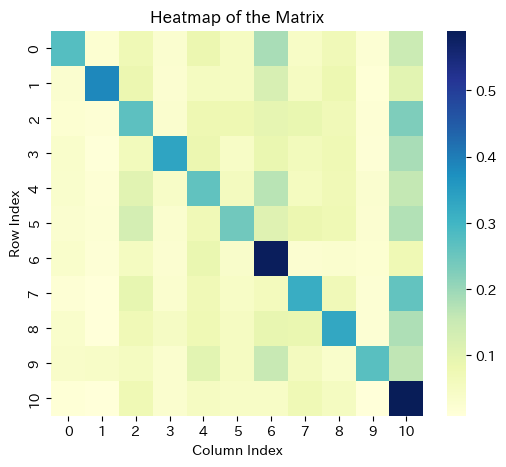


時点 1 から 2 への遷移行列:
各状態のエントロピー：[1.8145624  1.4161758  2.2304085  1.82274655 2.23707317 2.11634188
 2.09099881 2.10356894 2.17562359 1.64935969 2.24176533]

全体のエントロピー1.9907840594430846
      0     1     2     3     4     5     6     7     8     9     10
0  0.319 0.020 0.052 0.028 0.061 0.050 0.180 0.056 0.078 0.024 0.133
1  0.035 0.348 0.049 0.035 0.089 0.046 0.127 0.035 0.070 0.030 0.137
2  0.041 0.018 0.264 0.034 0.081 0.074 0.093 0.088 0.053 0.023 0.231
3  0.020 0.024 0.069 0.334 0.096 0.035 0.078 0.056 0.068 0.021 0.200
4  0.030 0.016 0.088 0.034 0.298 0.049 0.158 0.066 0.080 0.029 0.152
5  0.024 0.021 0.102 0.039 0.089 0.247 0.090 0.088 0.079 0.020 0.201
6  0.041 0.022 0.044 0.022 0.092 0.029 0.578 0.034 0.033 0.024 0.082
7  0.021 0.010 0.080 0.021 0.060 0.044 0.056 0.355 0.070 0.008 0.276
8  0.034 0.021 0.073 0.052 0.077 0.053 0.091 0.088 0.304 0.016 0.191
9  0.048 0.020 0.062 0.042 0.076 0.034 0.194 0.056 0.065 0.272 0.132
10 0.021 0.009 0.065 0.025 0.048 0.039 0.041 0.080 0.052 0

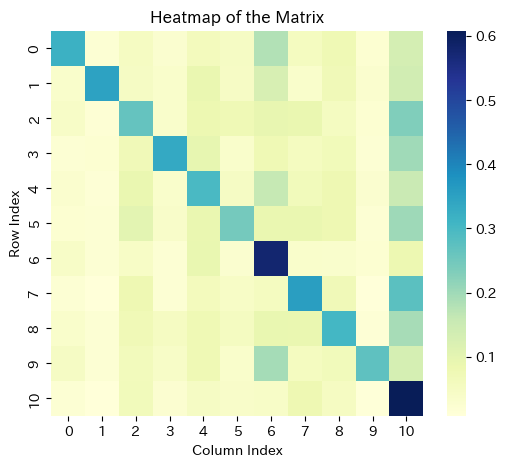


時点 2 から 3 への遷移行列:
各状態のエントロピー：[1.80031619 1.43527686 2.21823198 1.80796165 2.20711162 2.14160301
 2.07033482 2.15986536 2.17522317 1.75310029 2.24667796]

全体のエントロピー2.0014275373947488
      0     1     2     3     4     5     6     7     8     9     10
0  0.331 0.018 0.050 0.028 0.079 0.042 0.117 0.076 0.065 0.041 0.154
1  0.049 0.323 0.046 0.040 0.059 0.051 0.140 0.043 0.081 0.032 0.135
2  0.030 0.011 0.248 0.038 0.077 0.075 0.092 0.108 0.070 0.026 0.226
3  0.022 0.019 0.051 0.346 0.066 0.049 0.099 0.084 0.057 0.033 0.175
4  0.028 0.026 0.068 0.041 0.295 0.056 0.156 0.070 0.083 0.023 0.154
5  0.039 0.020 0.090 0.022 0.071 0.266 0.082 0.077 0.088 0.032 0.214
6  0.046 0.015 0.041 0.024 0.076 0.028 0.574 0.044 0.041 0.033 0.079
7  0.021 0.012 0.071 0.024 0.058 0.057 0.063 0.353 0.071 0.017 0.253
8  0.029 0.013 0.056 0.050 0.094 0.067 0.071 0.085 0.321 0.026 0.188
9  0.042 0.029 0.072 0.040 0.058 0.053 0.122 0.056 0.072 0.313 0.143
10 0.016 0.011 0.060 0.028 0.044 0.040 0.039 0.091 0.052 0

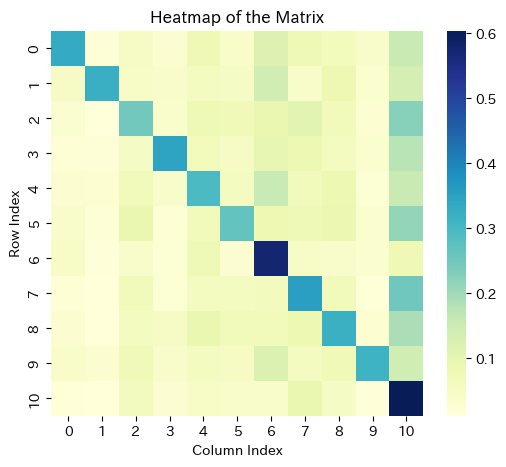


時点 3 から 4 への遷移行列:
各状態のエントロピー：[1.79829536 1.3191895  2.20481933 1.89427059 2.23198086 2.16178951
 2.04528562 2.17123606 2.163502   1.77682426 2.25060539]

全体のエントロピー2.0016180446116008
      0     1     2     3     4     5     6     7     8     9     10
0  0.311 0.027 0.054 0.024 0.075 0.049 0.167 0.061 0.057 0.040 0.134
1  0.029 0.393 0.040 0.054 0.072 0.043 0.097 0.052 0.046 0.023 0.152
2  0.021 0.017 0.246 0.039 0.070 0.085 0.076 0.100 0.070 0.025 0.251
3  0.026 0.017 0.046 0.313 0.071 0.037 0.077 0.075 0.105 0.026 0.208
4  0.034 0.023 0.079 0.035 0.293 0.047 0.152 0.054 0.081 0.025 0.178
5  0.020 0.020 0.111 0.031 0.080 0.230 0.082 0.085 0.086 0.029 0.227
6  0.043 0.016 0.033 0.026 0.087 0.034 0.571 0.039 0.046 0.026 0.078
7  0.022 0.007 0.071 0.036 0.064 0.047 0.061 0.326 0.071 0.016 0.280
8  0.039 0.016 0.066 0.043 0.074 0.068 0.063 0.091 0.333 0.025 0.183
9  0.052 0.021 0.060 0.039 0.087 0.039 0.129 0.060 0.093 0.268 0.151
10 0.018 0.013 0.057 0.024 0.048 0.037 0.041 0.083 0.048 0

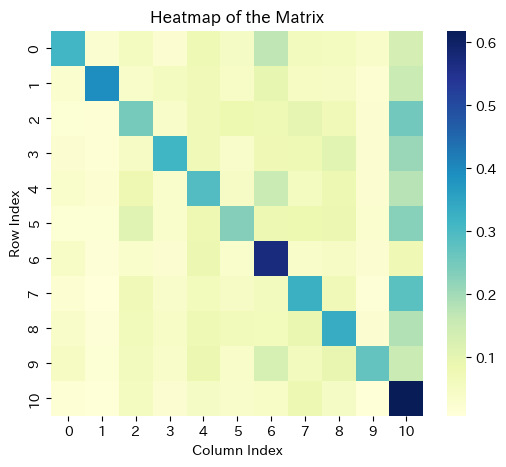


時点 4 から 5 への遷移行列:
各状態のエントロピー：[1.95825594 1.42226833 2.24014215 1.73166962 2.25017367 2.19359348
 2.08326797 2.15657746 2.22040891 1.65982899 2.25538726]

全体のエントロピー2.0155976161471725
      0     1     2     3     4     5     6     7     8     9     10
0  0.311 0.015 0.062 0.031 0.059 0.049 0.168 0.050 0.073 0.028 0.155
1  0.039 0.332 0.061 0.013 0.079 0.050 0.103 0.055 0.063 0.026 0.179
2  0.041 0.014 0.279 0.028 0.081 0.077 0.082 0.076 0.063 0.026 0.232
3  0.035 0.023 0.067 0.328 0.081 0.062 0.086 0.062 0.070 0.013 0.174
4  0.040 0.020 0.086 0.029 0.289 0.048 0.151 0.054 0.078 0.022 0.183
5  0.043 0.017 0.135 0.022 0.092 0.246 0.095 0.077 0.070 0.014 0.188
6  0.042 0.015 0.047 0.021 0.089 0.035 0.570 0.037 0.042 0.019 0.083
7  0.030 0.011 0.089 0.027 0.070 0.054 0.063 0.299 0.078 0.012 0.267
8  0.047 0.020 0.083 0.045 0.095 0.068 0.082 0.079 0.274 0.019 0.188
9  0.062 0.033 0.071 0.040 0.078 0.073 0.153 0.042 0.069 0.244 0.135
10 0.019 0.009 0.070 0.025 0.050 0.040 0.042 0.074 0.052 0

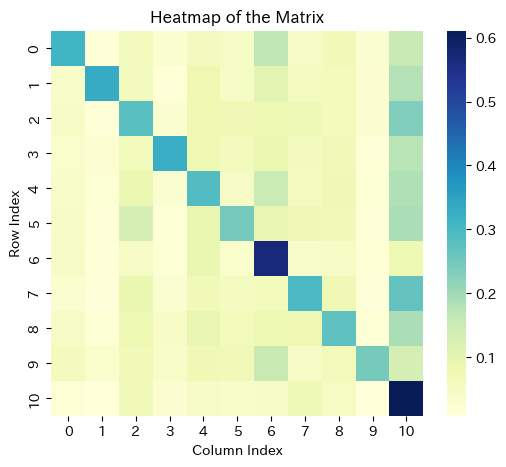


時点 5 から 6 への遷移行列:
各状態のエントロピー：[1.91310144 1.30960112 2.26667993 1.73338357 2.25185294 2.11933419
 2.07771763 2.03709848 2.13206461 1.49827887 2.25041663]

全体のエントロピー1.9626844921436764
      0     1     2     3     4     5     6     7     8     9     10
0  0.299 0.023 0.065 0.028 0.107 0.046 0.156 0.038 0.060 0.024 0.154
1  0.032 0.342 0.083 0.023 0.075 0.043 0.118 0.052 0.055 0.011 0.167
2  0.028 0.013 0.321 0.025 0.080 0.076 0.085 0.074 0.058 0.013 0.229
3  0.033 0.009 0.088 0.321 0.074 0.043 0.101 0.049 0.071 0.011 0.200
4  0.039 0.013 0.100 0.040 0.286 0.055 0.158 0.052 0.068 0.020 0.168
5  0.049 0.016 0.136 0.025 0.088 0.264 0.073 0.053 0.082 0.023 0.192
6  0.042 0.020 0.067 0.024 0.092 0.030 0.576 0.027 0.034 0.014 0.076
7  0.022 0.011 0.105 0.027 0.052 0.050 0.059 0.352 0.053 0.011 0.258
8  0.031 0.011 0.093 0.045 0.098 0.057 0.088 0.070 0.307 0.018 0.183
9  0.066 0.029 0.117 0.014 0.072 0.046 0.146 0.052 0.057 0.258 0.143
10 0.019 0.009 0.086 0.024 0.053 0.038 0.040 0.065 0.040 0

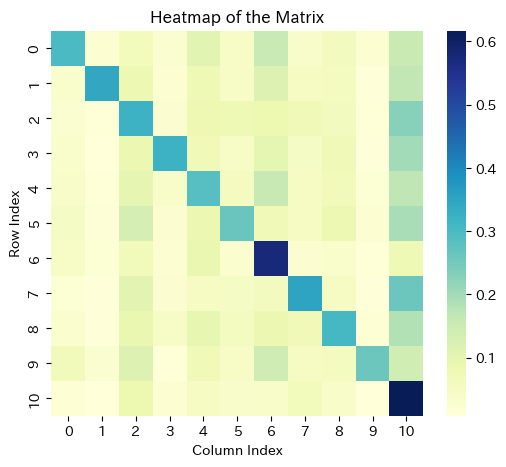


時点 6 から 7 への遷移行列:
各状態のエントロピー：[1.82132921 1.40092926 2.2660921  1.73780619 2.25765893 2.1764101
 2.07487651 2.06347569 2.04023437 1.5947962  2.23587243]

全体のエントロピー1.9699528161053363
      0     1     2     3     4     5     6     7     8     9     10
0  0.343 0.019 0.069 0.021 0.091 0.060 0.151 0.046 0.048 0.015 0.139
1  0.028 0.380 0.049 0.015 0.080 0.061 0.153 0.077 0.015 0.028 0.113
2  0.030 0.016 0.304 0.025 0.090 0.077 0.091 0.070 0.054 0.010 0.234
3  0.048 0.040 0.085 0.305 0.096 0.039 0.056 0.037 0.084 0.011 0.198
4  0.034 0.021 0.113 0.030 0.306 0.056 0.163 0.054 0.048 0.007 0.170
5  0.042 0.018 0.145 0.029 0.082 0.258 0.096 0.041 0.064 0.015 0.209
6  0.041 0.017 0.061 0.023 0.098 0.036 0.577 0.025 0.029 0.014 0.080
7  0.019 0.010 0.111 0.027 0.066 0.052 0.057 0.324 0.056 0.008 0.269
8  0.034 0.020 0.122 0.031 0.084 0.063 0.075 0.066 0.296 0.017 0.191
9  0.040 0.024 0.118 0.040 0.111 0.088 0.195 0.047 0.037 0.185 0.114
10 0.023 0.012 0.094 0.021 0.052 0.038 0.042 0.068 0.041 0.

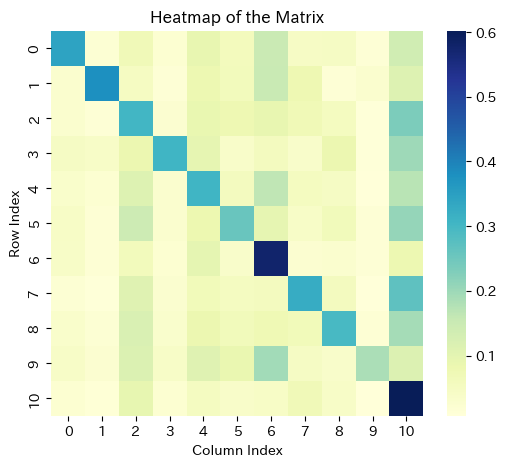


時点 7 から 8 への遷移行列:
各状態のエントロピー：[1.86349364 1.30486691 2.27059852 1.73055309 2.25169872 2.10222661
 2.08963459 2.04270956 2.12960079 1.3493214  2.2519477 ]

全体のエントロピー1.9442410492930904
      0     1     2     3     4     5     6     7     8     9     10
0  0.329 0.013 0.090 0.026 0.069 0.059 0.166 0.034 0.044 0.013 0.156
1  0.037 0.339 0.077 0.021 0.077 0.050 0.119 0.034 0.066 0.019 0.161
2  0.035 0.014 0.335 0.024 0.093 0.088 0.066 0.062 0.051 0.011 0.221
3  0.029 0.009 0.089 0.361 0.077 0.048 0.111 0.045 0.082 0.014 0.136
4  0.035 0.028 0.103 0.042 0.299 0.052 0.152 0.048 0.071 0.010 0.159
5  0.037 0.011 0.132 0.034 0.108 0.309 0.078 0.044 0.061 0.009 0.177
6  0.036 0.015 0.080 0.018 0.093 0.043 0.552 0.026 0.034 0.013 0.091
7  0.019 0.016 0.130 0.030 0.060 0.045 0.062 0.308 0.059 0.007 0.264
8  0.038 0.009 0.118 0.043 0.103 0.066 0.073 0.059 0.298 0.016 0.177
9  0.068 0.027 0.068 0.050 0.087 0.041 0.160 0.059 0.050 0.251 0.137
10 0.023 0.008 0.107 0.023 0.054 0.048 0.043 0.059 0.042 0

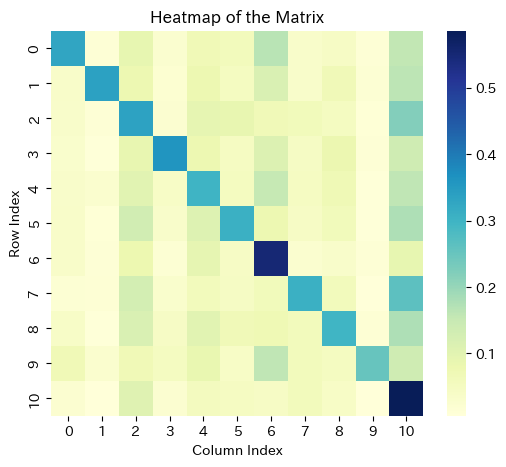


時点 8 から 9 への遷移行列:
各状態のエントロピー：[1.84255081 1.53810042 2.26385408 1.72909801 2.27079937 2.11289401
 2.0910545  2.03817768 2.11528013 1.46895748 2.26971667]

全体のエントロピー1.9764075588312187
      0     1     2     3     4     5     6     7     8     9     10
0  0.316 0.025 0.098 0.006 0.098 0.049 0.177 0.027 0.033 0.016 0.154
1  0.053 0.329 0.056 0.021 0.116 0.042 0.107 0.050 0.042 0.015 0.169
2  0.025 0.017 0.315 0.023 0.074 0.071 0.087 0.071 0.041 0.013 0.262
3  0.021 0.019 0.083 0.297 0.084 0.044 0.086 0.058 0.068 0.019 0.219
4  0.034 0.023 0.100 0.037 0.269 0.051 0.170 0.052 0.067 0.014 0.184
5  0.035 0.020 0.150 0.032 0.087 0.272 0.094 0.046 0.053 0.012 0.200
6  0.042 0.019 0.066 0.024 0.094 0.037 0.559 0.031 0.031 0.016 0.081
7  0.028 0.012 0.104 0.020 0.051 0.039 0.055 0.338 0.045 0.005 0.303
8  0.030 0.021 0.096 0.043 0.098 0.079 0.082 0.073 0.239 0.021 0.218
9  0.043 0.033 0.090 0.033 0.071 0.043 0.157 0.048 0.033 0.248 0.200
10 0.018 0.015 0.095 0.023 0.050 0.040 0.041 0.057 0.030 0

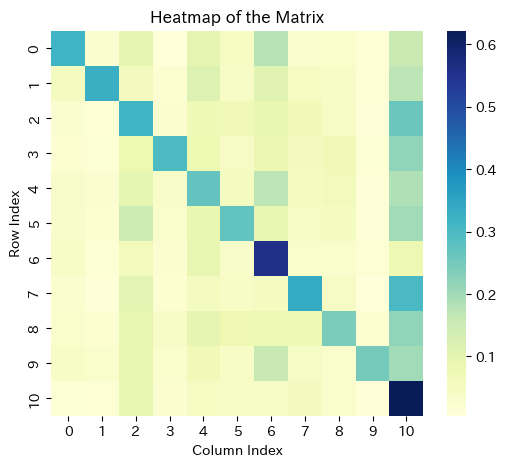


時点 9 から 10 への遷移行列:
各状態のエントロピー：[1.85903483 1.42475475 2.28456537 1.73575813 2.27776815 2.16648227
 2.09459458 2.02850558 2.0961445  1.501089   2.26475435]

全体のエントロピー1.9757683194537725
      0     1     2     3     4     5     6     7     8     9     10
0  0.331 0.017 0.098 0.028 0.078 0.048 0.160 0.040 0.031 0.012 0.157
1  0.048 0.345 0.079 0.020 0.071 0.046 0.112 0.028 0.051 0.013 0.188
2  0.035 0.013 0.317 0.024 0.081 0.081 0.087 0.067 0.035 0.014 0.247
3  0.025 0.018 0.086 0.309 0.093 0.053 0.109 0.028 0.074 0.014 0.193
4  0.051 0.034 0.106 0.030 0.264 0.063 0.160 0.050 0.054 0.016 0.172
5  0.035 0.017 0.137 0.022 0.090 0.274 0.100 0.053 0.060 0.009 0.204
6  0.040 0.018 0.065 0.021 0.080 0.038 0.588 0.028 0.029 0.014 0.080
7  0.024 0.013 0.126 0.025 0.069 0.049 0.065 0.291 0.048 0.010 0.282
8  0.042 0.018 0.107 0.042 0.095 0.072 0.090 0.050 0.265 0.017 0.203
9  0.031 0.028 0.098 0.031 0.087 0.098 0.142 0.035 0.055 0.217 0.177
10 0.021 0.010 0.096 0.020 0.048 0.043 0.042 0.059 0.033 

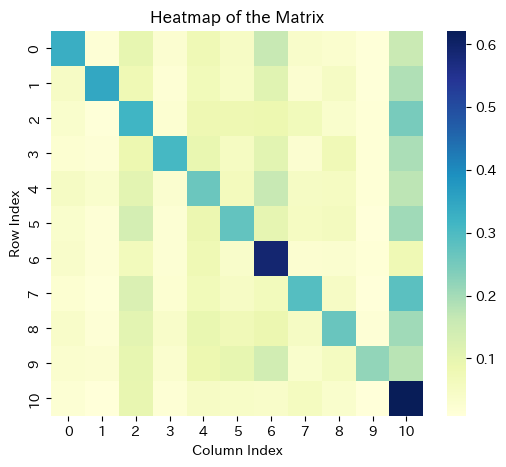


時点 10 から 11 への遷移行列:
各状態のエントロピー：[1.81272615 1.29798944 2.26784352 1.73680158 2.25916787 2.18545162
 2.09798667 2.05661803 2.04814223 1.58841591 2.23404313]

全体のエントロピー1.962289648514988
      0     1     2     3     4     5     6     7     8     9     10
0  0.378 0.020 0.058 0.027 0.067 0.066 0.155 0.039 0.057 0.013 0.120
1  0.042 0.352 0.063 0.037 0.069 0.061 0.135 0.042 0.037 0.021 0.140
2  0.031 0.014 0.312 0.024 0.086 0.081 0.091 0.078 0.051 0.015 0.217
3  0.030 0.015 0.102 0.343 0.063 0.048 0.089 0.060 0.058 0.024 0.168
4  0.048 0.022 0.116 0.031 0.263 0.076 0.170 0.040 0.069 0.013 0.152
5  0.040 0.014 0.141 0.036 0.076 0.286 0.097 0.044 0.072 0.014 0.181
6  0.039 0.020 0.061 0.019 0.091 0.043 0.587 0.023 0.025 0.017 0.076
7  0.021 0.009 0.116 0.020 0.079 0.049 0.063 0.323 0.059 0.007 0.254
8  0.044 0.009 0.108 0.042 0.071 0.065 0.099 0.071 0.311 0.016 0.165
9  0.063 0.017 0.121 0.033 0.075 0.092 0.142 0.059 0.029 0.213 0.155
10 0.018 0.012 0.090 0.024 0.048 0.050 0.042 0.071 0.037 

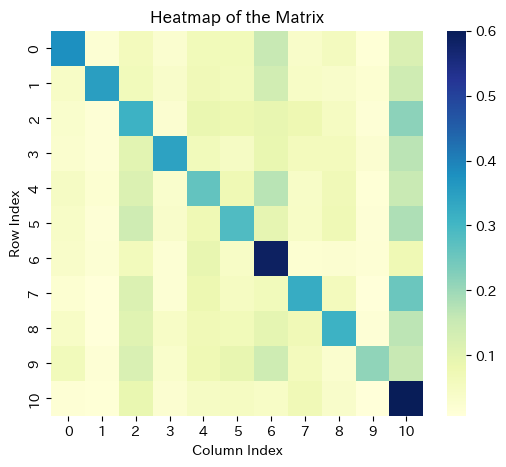

In [22]:
# 時点ごとの遷移行列を作成
import seaborn as sns
from scipy.stats import entropy
transition_matrices = create_time_dependent_transition_matrices(transtion_data)
# 時系列ごとのエントロピーを格納するリストを作成
each_ento_list=[]
# 全体のエントロピーを格納するためのリスト作成
all_ento_list=[]
# 結果の表示
for time, matrix in transition_matrices.items():
    print(f"\n時点 {time} から {time+1} への遷移行列:")
    print(f"各状態のエントロピー：{entropy(matrix)}")
    
    #各時点のエントロピーのリストを作成
    each_ento_list.append(entropy(matrix))
    print()
    print(f"全体のエントロピー{np.mean(entropy(matrix))}")
    
    #全体平均エントロピーのリストを作成
    all_ento_list.append(np.mean(entropy(matrix)))
    df_tra = pd.DataFrame(matrix).round(3)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)       # 出力の横幅を200文字に設定
    pd.set_option('display.float_format', '{:.3f}'.format)  # 小数点以下3桁表示
    print(df_tra)
   
    plt.figure(figsize=(6, 5))
    matrix = pd.DataFrame(matrix)
    sns.heatmap(df_tra, annot=False ,cmap='YlGnBu')
    plt.title('Heatmap of the Matrix')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # ヒートマップの表示
    plt.show()

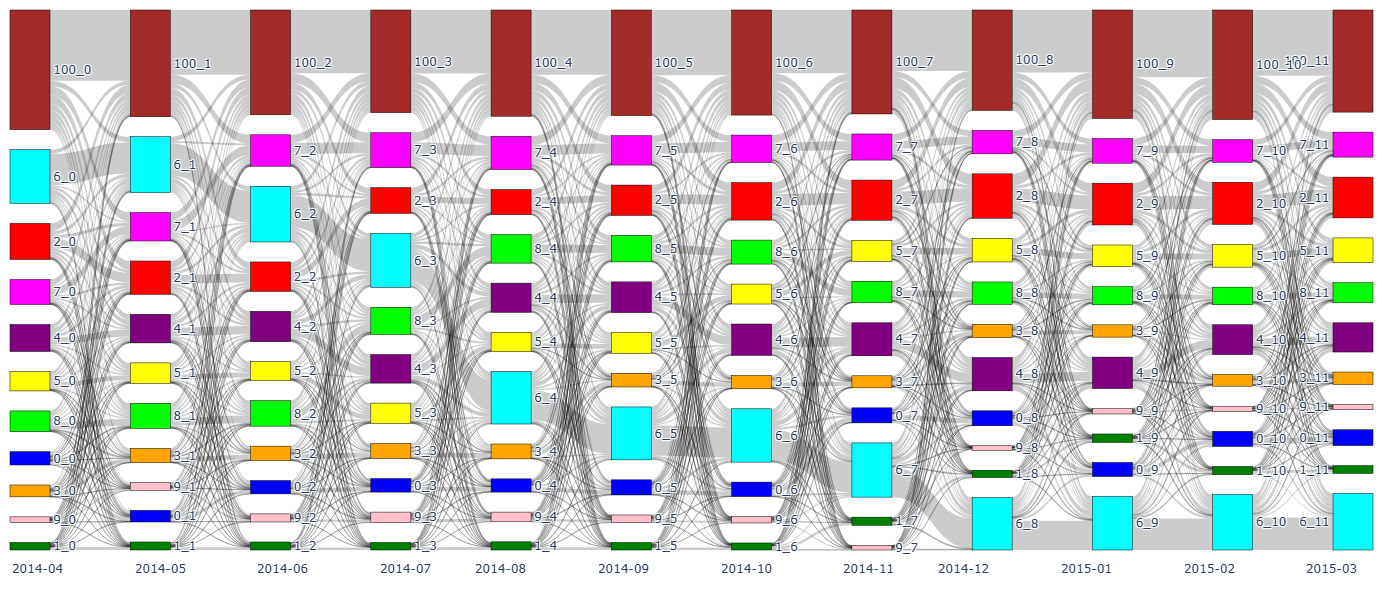

In [37]:
import pandas as pd
import plotly.graph_objects as go

def create_color_mapping():
    return {
        '0': 'blue', '1': 'green', '2': 'red', '3': 'orange',
        '4': 'purple', '5': 'yellow', '6': 'cyan', '7': 'magenta',
        '8': 'lime', '9': 'pink', '100':'brown'
    }

def prepare_sankey_data(source, target, values_list):
    unique_nodes = list(set(source + target))
    node_indices = {node: i for i, node in enumerate(unique_nodes)}

    color_mapping = create_color_mapping()
    color_list = [color_mapping[node.split('_')[0]] for node in unique_nodes]

    source_indices = [node_indices[node] for node in source]
    target_indices = [node_indices[node] for node in target]

    return unique_nodes, color_list, source_indices, target_indices

# def create_sankey_diagram(source, target, values_list):
#     unique_nodes, color_list, source_indices, target_indices = prepare_sankey_data(source, target, values_list)

#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=20,
#             thickness=40,
#             line=dict(color="black", width=0.5),
#             label=unique_nodes,
#             color=color_list
#         ),
#         link=dict(
#             source=source_indices,
#             target=target_indices,
#             value=values_list
#         )
#     )])

#     fig.update_layout(width = 2000, height = 600)
#     return fig

# # 使用例
# # source, target, values_list は前の処理から得られたものとする
# fig = create_sankey_diagram(source, target, values_list)
# fig.write_image("sankey_med.png", format="png", scale=2)  # 解像度調整にはscaleを使う
# fig.show()
import plotly.graph_objects as go

def create_sankey_diagram_with_dates(source, target, values_list, dates):
    unique_nodes, color_list, source_indices, target_indices = prepare_sankey_data(source, target, values_list)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=40,
            line=dict(color="black", width=0.5),
            label=unique_nodes,
            color=color_list
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values_list
        )
    )])

    # 各列に異なる年月を追加
    annotations = []
    for i, date in enumerate(column_dates):
        annotations.append(
            dict(
                text=date,  # 表示する年月
                x= i * 0.09,  # x軸を各列に対応（間隔を調整）
                y=-0.05,  # y軸の位置をグラフ上部に固定
                showarrow=False,
                font=dict(size=12),
                xref="paper",  # x座標を「描画エリア」で相対指定
                yref="paper"   # y座標を「描画エリア」で相対指定
            )
        )

    fig.update_layout(
        annotations=annotations,  # 全ての注釈を追加
        width=2000,
        height=600,
        margin=dict(l=10, r=10, t=10, b=50)  # 余白を調整
    )

    return fig


# 使用例
dates =pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()
fig = create_sankey_diagram_with_dates(source, target, values_list, dates)

# 保存時の余白を最小化
fig.write_image("sankey_med.png", format="png", scale=2, width=2000, height=650)  # 余白を考慮したサイズ
fig.show()

In [24]:
pip install kaleido

Note: you may need to restart the kernel to use updated packages.
